# 🐶 Dog Vision

This notebook builds an end-to-end multi-class image classifier using Tensorflow 2.0 and Tensorflow Hub.

I have used the [Dog Breed Identification Dataset](https://www.kaggle.com/competitions/dog-breed-identification/data) on [Kaggle](https://www.kaggle.com/) for the purposes of this project.

## The Goal

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

The evaluation is a file with prediction probabilities for each dog breed of each test image. You can check it out on [Kaggle](www.kaggle.com/competitions/dog-breed-identification/overview/evaluation).

## Resources

- [TensorFlow Tutorials Docs](https://www.tensorflow.org/tutorials)
- [Tensorflow Hub](https://www.tensorflow.org/hub)

## 1️⃣ Fetching the Dataset

In this step, we will fetch the zip file for the dog breed dataset that I am using and then we will unzip it. This step takes a while as there are more than 10,000 images in each of the training and testing folders.

**This is how we will do it**:

```bash
!unzip -qq $zip_file_path -d "/content/drive/MyDrive/DogVision"

# Execute the unzip command in the shell
# -qq flag stands for "quiet mode"
# It suppresses the output messages (like listing extracted files) for a cleaner log.
# $zip_file_path is a variable that holds the path to the ZIP file to be extracted
# -d flag specifies the destination directory where the files should be extracted
# The destination directory in this case is "/content/drive/MyDrive/DogVision"
# Files from the ZIP archive will be extracted into this folder.
```

In [ ]:
zip_file_path = "/content/drive/MyDrive/DogVision/dog-breed-identification.zip"
# !unzip -qq $zip_file_path -d "/content/drive/MyDrive/DogVision"

## 2️⃣ Importing the required packages and libraries + Getting our workspace ready

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from IPython.display import Image
import os
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub

In [ ]:
# Verify whether we were able to install everything successfully

print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU Availability

print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")
tf.config.list_physical_devices()

TF version: 2.15.0
TF Hub version: 0.16.1
GPU available


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 3️⃣ Getting our Data Ready

This step is essentially just **converting our data into tensors**.

- A tensor is a mathematical object used to represent data in multiple dimensions.
- It can be thought of as a generalization of scalars, vectors, and matrices: a scalar is a 0-dimensional tensor, a vector is a 1-dimensional tensor, and a matrix is a 2-dimensional tensor.
- Tensors can have any number of dimensions (also called "ranks"), and they are used extensively in fields like machine learning and physics to represent and manipulate data, such as images, text, or any other multi-dimensional data.
- In machine learning, tensors are often used as the fundamental data structure for inputs, weights, and outputs in neural networks.

With all machine learning models, our data needs to be in a numerical format.

### ⭐️ Exploring the data and converting it into numbers

In [ ]:
# Checkout the labels of our data
labels_csv = pd.read_csv("/content/drive/MyDrive/DogVision/labels.csv")
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [ ]:
labels_csv["breed"].value_counts()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
golden_retriever,67
brabancon_griffon,67
komondor,67


In [ ]:
labels_csv["breed"].value_counts().median()

82.0

`82.0` is great since it shows that our dataset is fairly balanced with regards to the number of images it has per class. You can read more about this in [Google's official documentation on training your own model](https://cloud.google.com/vertex-ai/docs/image-data/classification/prepare-data).

<Axes: xlabel='breed'>

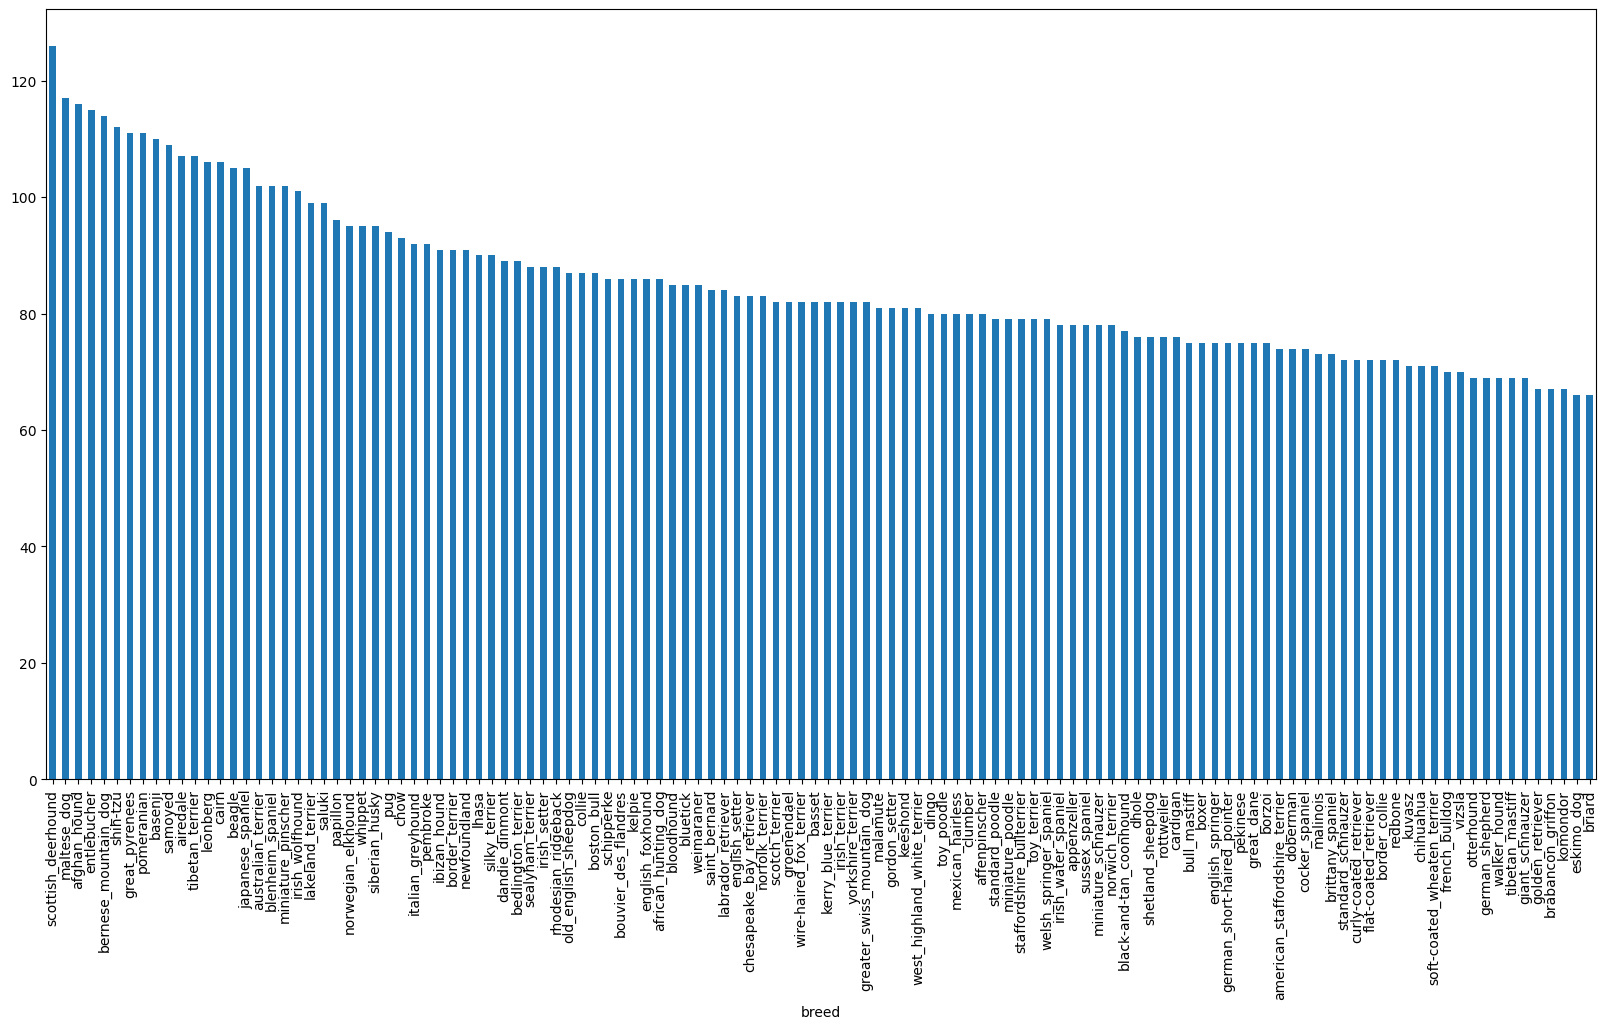

In [ ]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

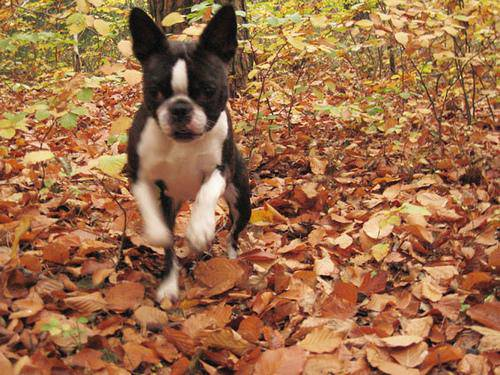

In [ ]:
# View images
Image("/content/drive/MyDrive/DogVision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

In [ ]:
labels_csv.head(3)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese


In [ ]:
# Getting a list of all of our image file pathnames
file_path = "/content/drive/MyDrive/DogVision/train/";
filenames = [file_path + fname + ".jpg" for fname in labels_csv["id"]]

# Is the number the same as the images in the dataframe
if len(os.listdir(file_path)) == len(filenames):
  print("✅ Filenames match actual amount of data")
else:
  print("❌ Filenames do not match the actual amount of data")

✅ Filenames match actual amount of data


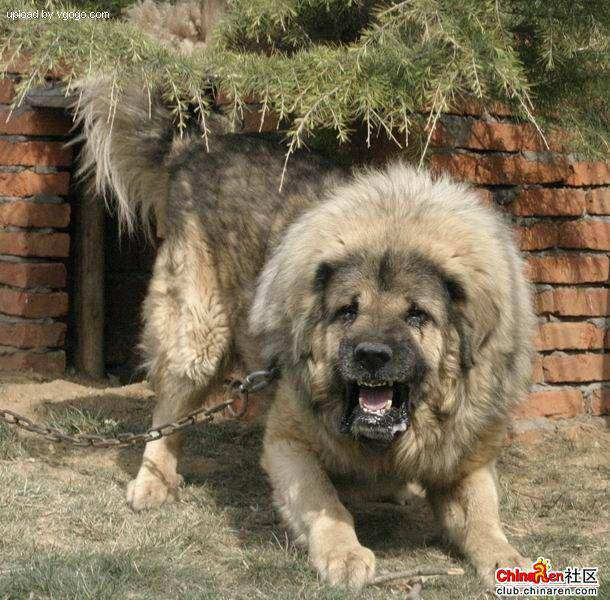

In [ ]:
Image(filenames[9000])

In [ ]:
# Let's prepare our labels
labels = labels_csv["breed"]
labels = np.array(labels) # Can also use labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if number of labels match the number of filenames
if len(labels) == len(filenames):
  print("✅ Filenames match number of labels")
else:
  print("❌ Filenames do not match the number of labels")


✅ Filenames match number of labels


In [ ]:
# We need to convert the strings to numbers somehow
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
len(unique_breeds) # We have 120 unique dog breeds

120

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn each label into an array of booleans
boolean_labels = [label == unique_breeds for label in labels]
len(boolean_labels)

10222

In [ ]:
# Turning boolean array into integers
print(labels[0])
print(np.where(unique_breeds == labels[0])) # Index where label occurs
print(boolean_labels[0].argmax()) # Index where label occus in boolean array

# This line will convert the bool array to an int array of 0s and 1s
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


Since we only got `train` and `test` images from Kaggle, we will have to create our own `validation` set.

In [ ]:
# Setup X and y variables
X = filenames
y = boolean_labels

len(filenames)

10222

We are going to start off by experimenting with ~1000 images and increase as needed.

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min: 1000, max: 10000}

In [ ]:
# Let us split our data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Let us have a gaze at the training data
X_train[:2], y_train[:2]

(['/content/drive/MyDrive/DogVision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/DogVision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, F

### ⭐️ Preprocessing Images (turning images into Tensors and Batches)

**Ref Docs:**
- <https://www.tensorflow.org/tutorials/load_data/images>
- <https://www.tensorflow.org/guide/data>
- <https://x.com/ylecun/status/989610208497360896?s=20>

We are going to write a function that does the following:

- Take an image file path as input
- Use Tensorflow to read the file and save it to a variable
- Turn our `image` into Tensors
- Resize the `image` to be a shape of (224, 224).
- Return the modified image.

In [ ]:
# Convert image to a NumPy array
image = plt.imread(filenames[42])
image.shape

(257, 350, 3)

This output is a tuple representing the dimensions of your image, which is stored as a NumPy array. Here's what each number signifies:

- **257:** This is the height of the image in pixels. It means there are 257 rows of pixels.
- **350:** This is the width of the image in pixels. It means there are 350 columns of pixels.
- **3:** This represents the number of color channels in the image. In this case, 3 typically indicates an RGB (Red, Green, Blue) image, where each pixel is represented by a combination of red, green, and blue values.

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]], dtype=uint8)
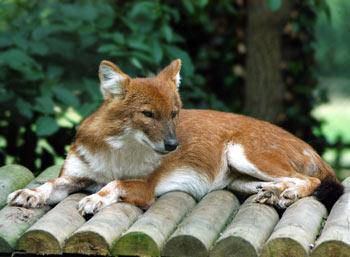

In [ ]:
image

In [ ]:
image.max()

255

In [ ]:
image.min()

0

In [ ]:
# Let us convert this into a Tensor
# This would allow us to run this on a GPU which is a lot faster
tf.constant(image[:2])

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [ ]:
# Define Image Size
# Feed data in the same format and shape as it was trained on
IMG_SIZE = 224

In [ ]:
# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor
  """

  # Read in an image file
  image = tf.io.read_file(image_path)

  # Turn the Jpeg image into a numerical Tensor with 3 color channels (Red, Green, and Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channel values to from 0-255 to 0-1 values (normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired value -> A Square (244, 244)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

**Tensorflow and Batches**

In **TensorFlow** (and machine learning in general), **batches** refer to subsets of the total dataset that are processed together in one step. Instead of feeding the entire dataset into the model all at once (which can be inefficient and require too much memory), we split the data into smaller chunks or "batches."

1. **Why Use Batches?**
   - **Memory Efficiency**: If you have a very large dataset, loading all the data into memory at once might not be possible. By processing data in smaller batches, you avoid overwhelming the system's memory.
   - **Faster Training**: Training a model on the entire dataset at once (called **batch processing**) can be slow. Batches allow for more frequent updates to the model's parameters (weights) without waiting for the entire dataset to be processed.
   - **Better Generalization**: Small batches help the model to learn in a way that can generalize better on unseen data. Training on large batches might lead to overfitting, where the model learns to perform well only on the training data and not on new, unseen data.

2. **How Batches Work in Practice:**
   - Imagine you have a dataset with 1000 examples, but you want to train a model using **batch size of 100**. This means that instead of feeding all 1000 examples into the model at once, you divide the dataset into 10 smaller batches, each containing 100 examples. The model will process one batch at a time, and after processing each batch, it will update its internal parameters based on that batch's data.
   
3. **Training Process in Batches:**
   - For each batch, the model makes predictions, calculates the error (loss), and adjusts the model's weights to reduce that error. After each batch is processed, the model is slightly improved. This is repeated for many batches until the model has seen the entire dataset, and training is complete.

4. **Batch Size**:
   - The **batch size** is the number of samples (data points) in one batch. It is a hyperparameter that you can tune based on the dataset and available computational resources. Common batch sizes include 32, 64, or 128, but it can vary.
   
   - A **small batch size** (e.g., 1 or a few examples) is called **stochastic gradient descent (SGD)**, where the model updates after each example. A **large batch size** (e.g., the entire dataset) is known as **batch gradient descent**.

5. **Training Loop**:
   - **Epoch**: One **epoch** is one complete pass through the entire dataset, processing all batches. If you have 1000 samples and a batch size of 100, one epoch would involve 10 batches.
   - The model will often train for many epochs to improve its performance.

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Testing the function
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we have got a way to turn our data into tuples of Tensors in the form: `(image, label)`. Let us make a function to turn all of our data (`X` & `y`) into batches.

In [ ]:
# Define the batch size, 32 is a good start
# Tensorflow defaults to 32 as well

BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it is validation data.

  Training Data: Shuffling helps the model learn general patterns and avoid overfitting to the order of data.
  Validation Data: Not shuffling ensures consistent evaluation of the model's ability to generalize to unseen data.

  Also accepts test data as input (no labels).
  """

  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("➡️ Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only file paths and no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("➡️ Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("➡️ Creating training data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

    # Shuffling pathnames and labels before mapping image prcessor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X)) # Shuffle the first len(X) examples

    # Create image label tuples (this also turns the image path into a prprocessed image)
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)

  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data = True)

➡️ Creating training data batches
➡️ Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### ⭐️ Visualizing data batches

Our data is now in batches but these are super hard to comprehend. Therefore, let us visualize them.

In [ ]:
# Create a function for viewing images in a data batch

def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """

  # Setup the figure
  plt.figure(figsize=(10, 10))

  # Loop through 25 (to display 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i + 1)

    # Display an image
    plt.imshow(images[i])

    # Add the image label as title
    plt.title(unique_breeds[labels[i].argmax()])

    # Turn the gridlines off
    plt.axis("Off")

In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

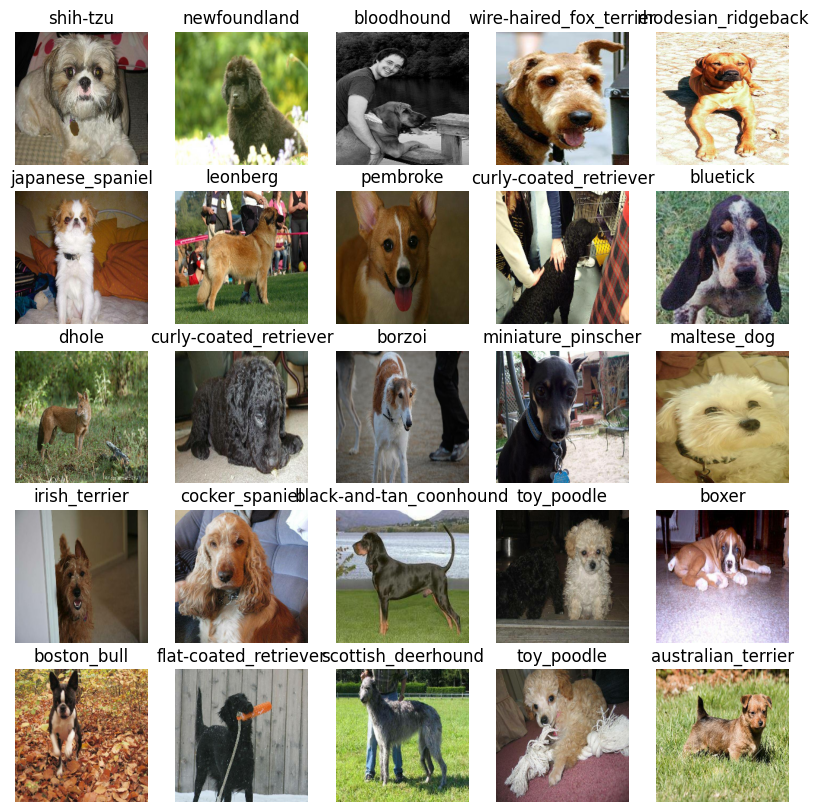

In [ ]:
# Now let us visualize our images in a training batch
show_25_images(train_images, train_labels)

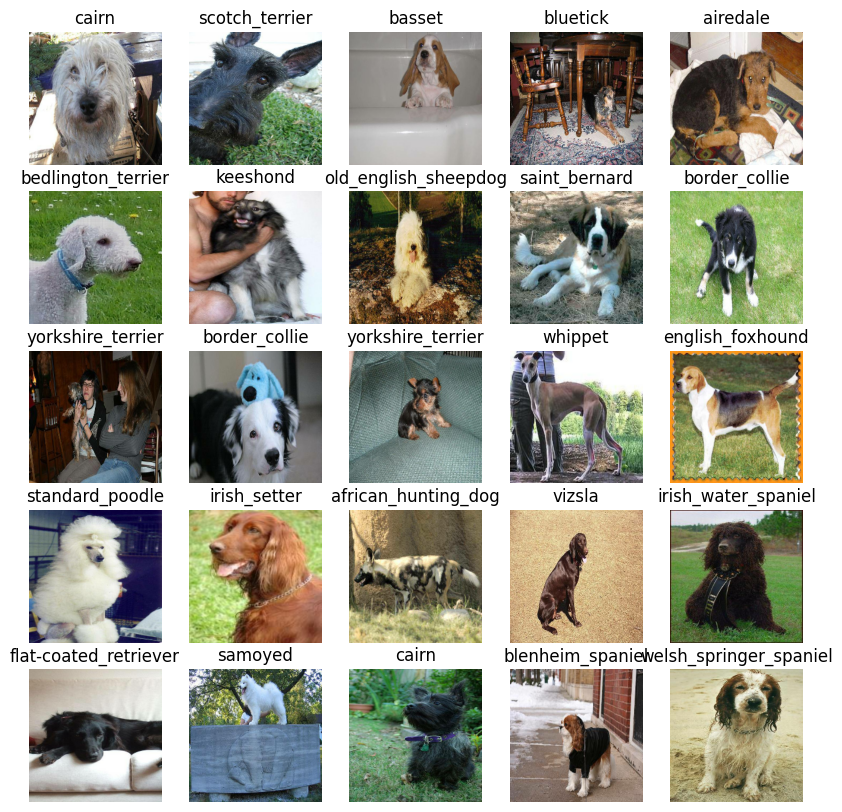

In [ ]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## 4️⃣ Building a model

Before we build a model, there are a few things we need to define:

- The input shape (our images shape in the form of Tensors) to our model.
- The output shape (image labels in the form of Tensors) of our model.
- The URL of the model we want to use.

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
# https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification/1?tfhub-redirect=true

MODEL_URL = "https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1"

Let us create a function which:

- Takes the input shape, output shape and the model we've chosen as parameters.
- Defines the layers in Keras model in Sequential fashion (do this first, then this, then that)
- Compiles the model (says it should be evaluated and improved)
- Builds the model (tells the model the input shape it'll be getting).
- Returns the model.

All of these steps can be found here:
- <https://www.tensorflow.org/guide/keras>
- <https://keras.io/api/models/sequential/>

In [ ]:
# Neural Networks typically consist of three main components:

# 1. Input Layer: The first layer that takes the input features for the model.
# 2. Hidden Layers: Intermediate layers where computations and transformations occur.
# 3. Output Layer: The final layer that provides predictions or outputs.

# Define a function to create and return a Keras model with specified configurations.
# Arguments:
# - input_shape: Shape of the input data. Default is a global constant INPUT_SHAPE.
# - output_shape: Number of output classes (for classification tasks). Default is a global constant OUTPUT_SHAPE.
# - model_url: URL of a pre-trained model to use as a base. Default is a global constant MODEL_URL.

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):

  # Print a log message indicating which pre-trained model will be used.
  print("➡️ Building model with: ", model_url)

  # Initialize a Sequential model, which allows for stacking layers linearly.
  model = tf.keras.Sequential([
      # Add a pre-trained model layer from TensorFlow Hub. This layer serves as a feature extractor.
      #
      hub.KerasLayer(model_url),

      # Add a Dense layer for classification.
      # - 'units=output_shape' specifies the number of output classes.
      # - 'activation="softmax"' is used for multi-class classification to output probabilities for each class.
      tf.keras.layers.Dense(units=output_shape, activation="softmax")
  ])

  # Compile the model. This step configures the model for training.
  model.compile(
      # Specify the loss function as categorical crossentropy, used for multi-class classification problems.
      loss=tf.keras.losses.CategoricalCrossentropy(),

      # Use Adam optimizer, which is a commonly used gradient-based optimization algorithm.
      optimizer=tf.keras.optimizers.Adam(),

      # Specify 'accuracy' as the metric to evaluate during training and testing.
      metrics=['accuracy']
  )

  # Build the model with the specified input shape.
  # This initializes the model weights and ensures compatibility with the input data.
  model.build(INPUT_SHAPE)

  # Return the fully constructed and compiled model.
  return model

In [ ]:
model = create_model()
model.summary()

➡️ Building model with:  https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_1 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________
